# Load Libraries

In [2]:
%run "00 - PSO Data Load Basic lib.ipynb"

## Load a plan from a live instance of PSO
beware to have this notebook working you need to have setup the psoconfig.txt file properly and the dataset needs to be running
the example underneath is using the LXDEMO dataset available in the ifs community at : https://ifs.community.com

In [2]:
# Get PSO authorization
global psotoken
psourl, accountid, user, password = read_config_file("../config/psoconfig.txt")
psotoken = get_session_token(psourl, accountid, user, password)

NameError: name 'read_config_file' is not defined

In [2]:
planXML = get_plan_xml("LXDEMO",psotoken) # Get XML Records of interest from plan

# Parse the XML file and create the DataFrame
df_activities = parse_records_to_dataframe_by_string(planXML,'Activity')
df_activities_sla = parse_records_to_dataframe_by_string(planXML,'Activity_SLA')
df_plan_travel = parse_records_to_dataframe_by_string(planXML,'Plan_Travel')
df_locations = parse_records_to_dataframe_by_string(planXML,'Location')
df_allocations = parse_records_to_dataframe_by_string(planXML,'Allocation')


## Build a fact table for Activities joining more dataframes

In [3]:
# Create a dataframe of activities selecting from df_activities the columns: id, activity_type_id, location_id, duration and renaming id to activity_id
df_fact_activities = df_activities[[
    'id', 'activity_type_id', 'location_id', 'duration']].rename(columns={'id': 'activity_id'})

# join df_fact_activities with df_activities_sla by activity_id where sla_type_id is 'Normal'
df_fact_activities = pd.merge(
    df_fact_activities, df_activities_sla[df_activities_sla['sla_type_id'] == 'Default'][[
        'activity_id', 'datetime_start', 'datetime_end']], how='left', left_on='activity_id', right_on='activity_id')

# join df_fact_activities with df_locations by location_id and select columns latitude, longitude and city
df_fact_activities = pd.merge(
    df_fact_activities, df_locations[[
        'id', 'latitude', 'longitude', 'city']], how='left', left_on='location_id', right_on='id')


# join df_fact_activities with df_allocations by activity_id and select columns resource_id, activity_start, activity_end

df_fact_activities = pd.merge(
    df_fact_activities, df_allocations[[
        'activity_id','resource_id', 'activity_start', 'activity_end']], how='left', left_on='activity_id', right_on='activity_id')

# join df_fact_activities with df_plan_travel by activity_id and select columns shift_start_datetime, shift_end_datetime, shift_start_time, shift_end_time, shift_start_date and shift_end_date

# and remove the id column from df_fact_activities
df_fact_activities = df_fact_activities.drop(['id'], axis=1)

# Convert expected_travel_time from ISO 8601 format to timedelta
df_plan_travel['expected_travel_time'] = df_plan_travel['expected_travel_time'].apply(
    isodate.parse_duration)

# Calculate the difference between end_time and start_time and day of the shift
df_plan_travel['real_travel_time'] = (
    df_plan_travel['end_time'] - df_plan_travel['start_time'])
df_plan_travel['shift_day'] = df_plan_travel['shift_start_datetime'].dt.date

# join df_fact_activities with df_plan_travel by activity_id and select distance, expected_travel_time, real_travel_time and shift_day
df_fact_activities = pd.merge(df_fact_activities, df_plan_travel[[
                              'activity_id', 'distance', 'expected_travel_time', 'real_travel_time', 'shift_day']], how='left', left_on='activity_id', right_on='activity_id')

## Data Cleansing and Filtering

In [4]:
# Remove from fact_activities the rows where activity_type_id is 'EV_CHARGER' and 'VACATION'
df_filtered_fact_activities = df_fact_activities[df_fact_activities['activity_type_id']!= 'EV_CHARGER']
df_filtered_fact_activities = df_filtered_fact_activities[df_fact_activities['activity_type_id']!= 'VACATION']


C:\Users\fesegb\AppData\Local\Temp\ipykernel_30112\1143317099.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_fact_activities = df_filtered_fact_activities[df_fact_activities['activity_type_id']!= 'VACATION']


# Plot a Pie Chart with seaborn from df_filtered_fact_activities by activity_type_id

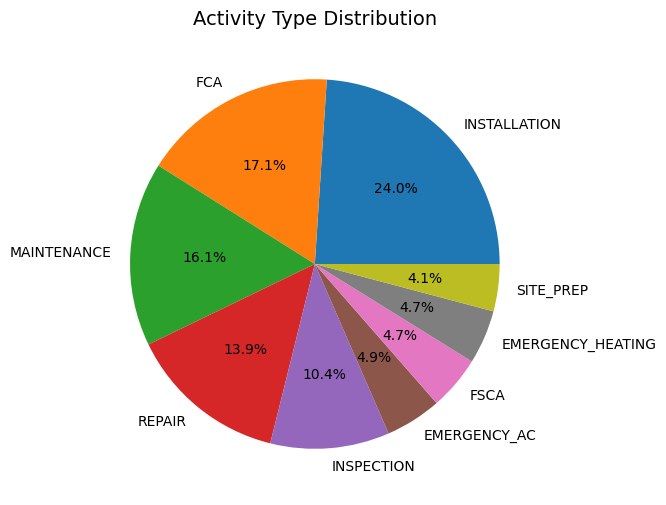

In [5]:
# plot a nice pie chart with seaborn from df_filtered_fact_activities by activity_type_id

fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(df_filtered_fact_activities['activity_type_id'].value_counts(), labels=df_filtered_fact_activities['activity_type_id'].value_counts().index, autopct='%1.1f%%')
ax.set_title('Activity Type Distribution', fontsize=14)
plt.show()


# Plot Map of Activities

In [6]:
import folium
from folium.plugins import MarkerCluster

# Coordinates for the center in Raleigh
map_center = [35.7930215,-78.6621723]

# Create a Folium map centered 
map = folium.Map(location=map_center, zoom_start=10)

#map

In [7]:
#Get latitude and longitude
locations_data = np.array(df_filtered_fact_activities[['latitude','longitude']].astype(float))
popups_data = ["lon:{}<br>lat:{}".format(longitude, latitude) for (longitude,latitude) in np.array(df_filtered_fact_activities[['longitude', 'latitude']])]

# Create the Marker
marker_cluster = MarkerCluster(locations=locations_data,popups=popups_data)
marker_cluster.add_to(map)

map

## Plot the time difference between actual and expected travel time

In [8]:
# Group by resource_id and calculate the total time difference for each resource
# remove from df_filtered_fact_activities rows where resource_id is Nan

df_filtered_fact_activities['resource_id']= df_filtered_fact_activities['resource_id'].fillna('')
df_filtered_fact_activities_2Xtechs = df_filtered_fact_activities[df_filtered_fact_activities['resource_id'].str.contains('(R2)',regex=True)]
filtered_grouped_df = df_filtered_fact_activities_2Xtechs.groupby(['resource_id','shift_day'])[['real_travel_time','expected_travel_time']].sum().reset_index()

C:\Users\fesegb\AppData\Local\Temp\ipykernel_30112\189175712.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtered_fact_activities_2Xtechs = df_filtered_fact_activities[df_filtered_fact_activities['resource_id'].str.contains('(R2)',regex=True)]


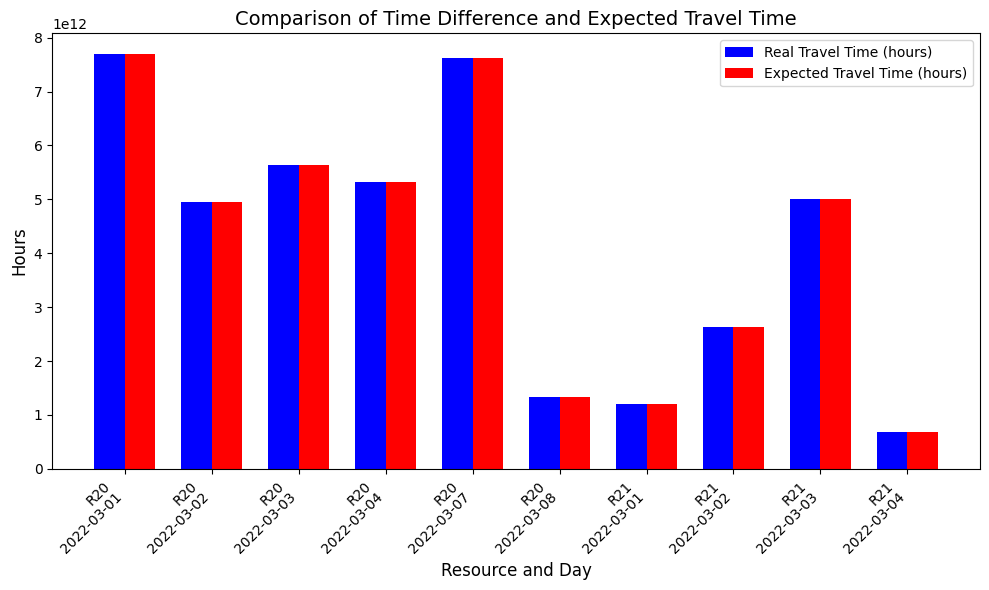

In [9]:
# Plotting the histogram
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plots
bar_width = 0.35
bar_positions = list(range(len(filtered_grouped_df)))

# Plot time differences
ax.bar(bar_positions, filtered_grouped_df['real_travel_time'], width=bar_width, label='Real Travel Time (hours)', color='b')

# Plot expected travel times
ax.bar([p + bar_width for p in bar_positions], filtered_grouped_df['expected_travel_time'], width=bar_width, label='Expected Travel Time (hours)', color='r')

# Set the labels and title
ax.set_xlabel('Resource and Day', fontsize=12)
ax.set_ylabel('Hours', fontsize=12)
ax.set_title('Comparison of Time Difference and Expected Travel Time', fontsize=14)
ax.set_xticks([p + bar_width / 2 for p in bar_positions])
#ax.set_xticklabels([f"{row['resource_id']}\n{row['shift_day']}" for _, row in grouped_df.iterrows()])
ax.set_xticklabels([f"{row['resource_id']}\n{row['shift_day']}" for _, row in filtered_grouped_df.iterrows()], fontsize=10, rotation=45, ha='right')
ax.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

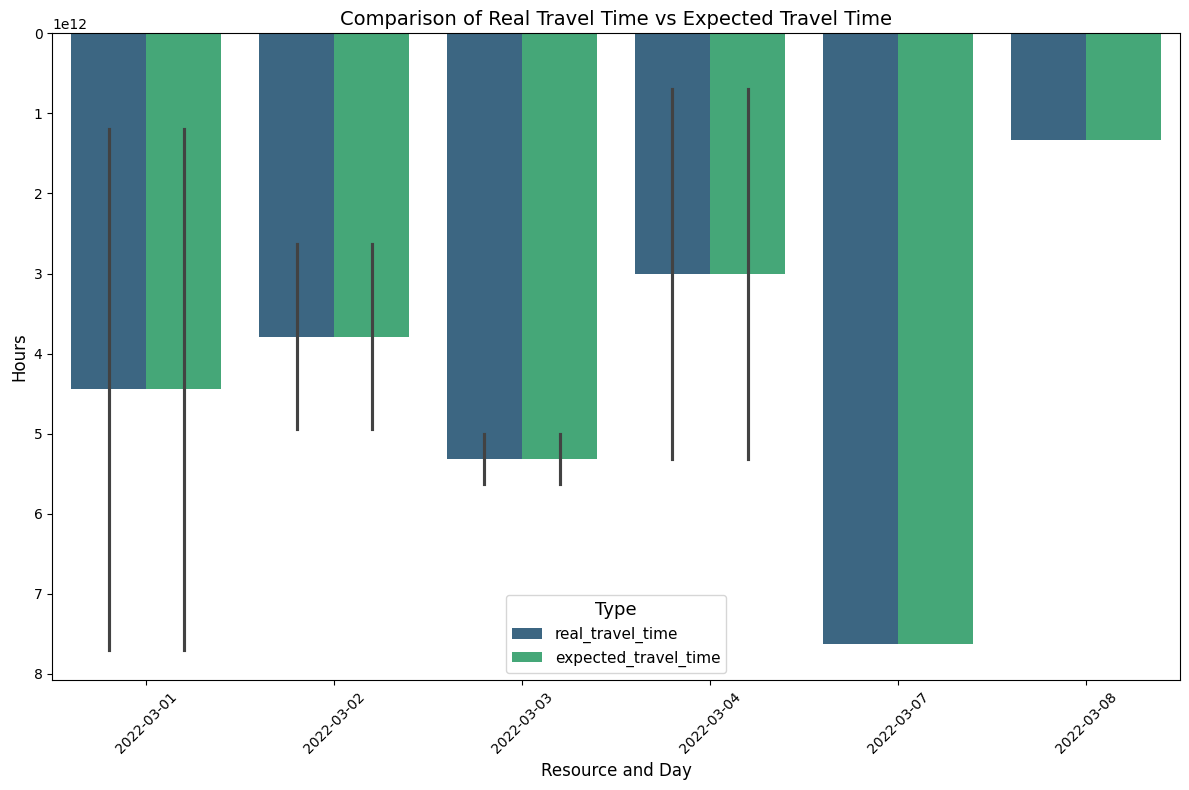

In [10]:
# Melt the DataFrame for seaborn
melted_df = filtered_grouped_df.melt(id_vars=['resource_id', 'shift_day'], 
                            value_vars=['real_travel_time', 'expected_travel_time'], 
                            var_name='Type', value_name='Hours')

# Plotting with seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_df, x='shift_day', y='Hours', hue='Type', palette='viridis')

# Customize the plot
plt.xlabel('Resource and Day', fontsize=12)
plt.ylabel('Hours', fontsize=12)
plt.title('Comparison of Real Travel Time vs Expected Travel Time', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Type', title_fontsize='13', fontsize='11')

# Display the plot
plt.tight_layout()
plt.show()